** This file gives a brief overview of the capabilities of the code. **

* The codes fit red arm spectra from Magellan/MIKE. 

* Since the codes are meant to be clean and minimal, it should not be hard to tweak the source codes for other purposes (say fitting the blue arm spectrum).

* The code fit for basic stellar parameters (Teff, logg, [Fe/H], [$\alpha$/Fe]), the broadening $v_{\rm broad}$, radial velocity, and continuum, to all spectral orders, simultaneously.

In [1]:
%matplotlib inline

# import packages
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import signal
from scipy.stats import norm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

from cycler import cycler

# import The Payne (https://github.com/tingyuansen/The_Payne)
from Payne4MIKE import spectral_model
from Payne4MIKE import utils
from Payne4MIKE import fitting
from Payne4MIKE.read_spectrum import read_carpy_fits


In [2]:
# define plot properties
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(10,10,10), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (11,7.5)
rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

rcParams['font.family'] = 'Bitstream Vera Sans' 
rcParams['font.size'] = 25
rcParams['font.weight'] = 300


> Restore The Payne emulator.

In [3]:
# assuming Kurucz models
NN_coeffs, wavelength_payne = utils.read_in_neural_network()
w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max = NN_coeffs


> Read in MIKE spectra.

In [4]:
# an example of a MIKE spectrum to be fitted
wavelength, spectrum, spectrum_err = utils.read_in_example()

# or restore your own here
#read_path =  "star-2red_multi.fits"
#wavelength, spectrum, spectrum_err = read_carpy_fits(read_path)

#-----------------------------------------------------------------------------------
# restore a default hot star spectrum to determine telluric features
wavelength_blaze, spectrum_blaze, spectrum_err_blaze = utils.read_in_blaze_spectrum()

# or restore your own here
#read_path =  "Hot_Star_HR9087.fits"
#wavelength_blaze, spectrum_blaze, spectrum_err_blaze = read_carpy_fits(read_path)



/Users/yting/anaconda3/lib/python3.7/site-packages/Payne4MIKE-0.1-py3.7.egg/Payne4MIKE/read_spectrum.py:98: RuntimeWarning: divide by zero encountered in power
  ivar = image[0].data[noise_ext]**(-2)


> Massaging the spectra into a digestable format.

In [5]:
# cull nonsensible values
spectrum = np.abs(spectrum)
spectrum_blaze = np.abs(spectrum_blaze)

# truncate the end of each orders as they can contain nonsensible values
spectrum = spectrum[:,30:-15]
spectrum_err = spectrum_err[:,30:-15]
wavelength = wavelength[:,30:-15]

# match the wavelength (blaze -> spectrum)
spectrum_blaze, wavelength_blaze = utils.match_blaze_to_spectrum(wavelength, spectrum, wavelength_blaze, spectrum_blaze)

# use the blaze to determine telluric region
spectrum_err = utils.mask_telluric_region(spectrum_err, spectrum_blaze)


> Fit the spectrum.

In [6]:
# the range of RV that we will search (in the unit of 100 km/s)
# expand/refine the range of RV if the fit is stuck in a local minimum
RV_array=np.linspace(-1,1.,6)

popt_best = fitting.fitting_mike(spectrum, spectrum_err, spectrum_blaze,\
                                 wavelength, NN_coeffs, wavelength_payne,\
                                 RV_prefit=True, blaze_normalized=True,\
                                 RV_array=RV_array)

# print best parameters
# recale back
popt_best_copy = np.copy(popt_best)
popt_best[:4] = (popt_best[:4] + 0.5)*(x_max-x_min) + x_min
popt_best[0] = popt_best[0]*1000.
popt_best[-1] = popt_best[-1]*100.
print("[Teff [K], logg, Fe/H, Alpha/Fe] = ",\
      int(popt_best[0]*1.)/1.,\
      int(popt_best[1]*100.)/100.,\
      int(popt_best[2]*100.)/100.,\
      int(popt_best[3]*100.)/100.)
print("vbroad [km/s] = ", int(popt_best[-2]*10.)/10.)
print("RV [km/s] = ", int(popt_best[-1]*10.)/10.)



(1, 4051)
(1, 4051)
(1, 4051)
Finding the best initial radial velocity
0 / 6
(9,)
1 / 6
(9,)
2 / 6
(9,)
3 / 6
(9,)
4 / 6
(9,)
5 / 6
(9,)
[Teff [K], logg, Fe/H, Alpha/Fe] =  4929.0 1.29 -0.37 -0.19
vbroad [km/s] =  1.7
RV [km/s] =  -40.3


In [7]:
RV_array = np.array([popt_best[-1]])
popt_best = fitting.fitting_mike(spectrum, spectrum_err, spectrum_blaze,\
                                 wavelength, NN_coeffs, wavelength_payne,\
                                 RV_prefit=False, blaze_normalized=True,\
                                 RV_array=RV_array)

# print best parameters
# recale back
popt_best_copy = np.copy(popt_best)
popt_best[:4] = (popt_best[:4] + 0.5)*(x_max-x_min) + x_min
popt_best[0] = popt_best[0]*1000.
popt_best[-1] = popt_best[-1]*100.
print("[Teff [K], logg, Fe/H, Alpha/Fe] = ",\
      int(popt_best[0]*1.)/1.,\
      int(popt_best[1]*100.)/100.,\
      int(popt_best[2]*100.)/100.,\
      int(popt_best[3]*100.)/100.)
print("vbroad [km/s] = ", int(popt_best[-2]*10.)/10.)
print("RV [km/s] = ", int(popt_best[-1]*10.)/10.)

(34, 4051)
(34, 4051)
(34, 4051)
First fitting the blaze-normalized spectrum
0 / 1
(108,)


NameError: free variable 'wavelength_normalized' referenced before assignment in enclosing scope

> Fit all orders simultaneously (pre-normalized).

In [8]:
# fit spectrum
def fit_func(dummy_variable, *labels):
    
    # make payne models
    full_spec_1 = spectral_model.get_spectrum_from_neural_net(\
                               scaled_labels = labels[:4],
                               NN_coeffs = NN_coeffs)
    
    # convolution with vmacro
    win = norm.pdf((np.arange(21)-10.)*(wavelength_payne[1]-wavelength_payne[0]),\
                    scale=labels[-2]/3e5*5000)
    win = win/np.sum(win)
    full_spec_2 = signal.convolve(full_spec_1, win, mode='same')
    
    # RV shift
    full_spec_3 = utils.doppler_shift(wavelength_payne, full_spec_2, labels[-1]*100.)
        
    # interpolate into the wavelength chunk
    f_flux_spec = interpolate.interp1d(wavelength_payne, full_spec_3)
    
#----------------------------------------------------------------------
    # make prediction
    spec_predict = np.zeros(wave_fit.shape)
    
    # loop over all orders
    for k in range(wave_fit.shape[0]):
        norm_spec = f_flux_spec(wave_fit[k,:])
    
        # fit for the continuum
        scale_poly = wave_fit_normalized[k,:]**2*labels[4+3*k] \
                    + wave_fit_normalized[k,:]*labels[5+3*k] + labels[6+3*k]
        
        # record results
        spec_predict[k,:] = norm_spec*scale_poly
        
    return spec_predict.ravel()


#====================================================================
# first four are stellar parametes (Teff, logg, Fe/H, alpha/Fe)
# then the polynomial (3 parameters per order)
# then vamcro
# then RV
p0 = np.zeros(4 + 3*wave_fit.shape[0] + 1 + 1)

# initiate the polynomial with a flat scaling of y=1
p0[4::3] = 0
p0[5::3] = 0
p0[6::3] = 1
    
# initialize vmacro at 3 km/s
p0[-2] = 0.5
    
# initiate RV with the previously best fitted RV
p0[-1] = popt_best_copy[-1]

#----------------------------------------------------------------------
# set fitting bound
bounds = np.zeros((2,p0.size))
bounds[0,:4] = -0.5
bounds[1,:4] = 0.5
bounds[0,4:] = -1000
bounds[1,4:] = 1000  
bounds[0,-2] = 0.1
bounds[1,-2] = 10.
bounds[0,-1] = -200
bounds[1,-1] = 200 

#----------------------------------------------------------------------
# run the optimizer
import time
start_time = time.time()
tol = 5e-4 
popt_best, pcov = curve_fit(fit_func, xdata=[], ydata = spec_observe,\
                       sigma = spec_err_observe, p0 = p0, bounds=bounds,\
                       ftol = tol, xtol = tol, absolute_sigma = True,\
                       method = 'trf')
print(time.time()-start_time)

# calculate chi^2
model_spec = fit_func([], *popt_best)
non_telluric = spec_err_observe < 1.
chi_2 = np.mean((spec_observe[non_telluric]-model_spec[non_telluric])**2\
                             /spec_err_observe[non_telluric]**2)

#----------------------------------------------------------------------
# print best parameters
# recale back
popt_best_copy = np.copy(popt_best)
popt_best[:4] = (popt_best[:4] + 0.5)*(x_max-x_min) + x_min
popt_best[0] = popt_best[0]*1000.
popt_best[-1] = popt_best[-1]*100.
print("[Teff [K], logg, Fe/H, Alpha/Fe] = ",\
      int(popt_best[0]*1.)/1.,\
      int(popt_best[1]*100.)/100.,\
      int(popt_best[2]*100.)/100.,\
      int(popt_best[3]*100.)/100.)
print("vbroad [km/s] = ", int(popt_best[-2]*10.)/10.)
print("RV [km/s] = ", int(popt_best[-1]*10.)/10.)
print("Chi square = ", chi_2)


169.4416229724884
[Teff [K], logg, Fe/H, Alpha/Fe] =  4536.0 1.29 -0.63 -0.19
vbroad [km/s] =  1.9
RV [km/s] =  -39.8
Chi square =  17.463093367943955


In [ ]:
169.4416229724884
[Teff [K], logg, Fe/H, Alpha/Fe] =  4536.0 1.29 -0.63 -0.19
vbroad [km/s] =  1.9
RV [km/s] =  -39.8
Chi square =  17.463093367943955

> Initiate continuum.

In [7]:
# normalize spectra with the blaze function
spec_observe = spectrum/spectrum_blaze
spec_err_observe = spectrum_err/spectrum_blaze

spec_observe_unmodulated = np.copy(spectrum)
spec_err_observe_unmodulated = np.copy(spectrum_err)

wave_fit = np.copy(wavelength)

# further prescale the spectrum
spec_observe, spec_err_observe = utils.scale_spectrum_by_median(spec_observe, spec_err_observe)
spec_observe_unmodulated, spec_err_observe_unmodulated = utils.scale_spectrum_by_median(spec_observe_unmodulated, spec_err_observe_unmodulated)
    
#---------------------------------------------------------------------
# flatten for chi2 minimization
spec_observe = spec_observe.ravel()
spec_err_observe = spec_err_observe.ravel()
spec_observe_unmodulated = spec_observe_unmodulated.ravel()
spec_err_observe_unmodulated = spec_err_observe_unmodulated.ravel()

# normalize wavelength grid
wave_fit_normalized = utils.whitten_wavelength(wave_fit)


In [9]:
# initiate results
fit_poly = np.zeros((wave_fit_normalized.shape[0],7))

# loop over all order
for k in range(wave_fit_normalized.shape[0]):
    
    # the current polynomial fit
    pre_poly = wave_fit_normalized[k,:]**2*popt_best_copy[4+3*k] \
                        + wave_fit_normalized[k,:]*popt_best_copy[5+3*k] + popt_best_copy[6+3*k]

    # fit polynomial
    model_spec_temp = model_spec[k*wave_fit.shape[1]:(k+1)*wave_fit.shape[1]]
    x_poly = wave_fit_normalized[k,:]*100.
    fit_poly[k,:] = np.polyfit(x_poly,\
                      spec_observe_unmodulated[k*wave_fit.shape[1]:(k+1)*wave_fit.shape[1]]/(model_spec_temp/pre_poly), 6,\
                      w=1./(spec_err_observe_unmodulated[k*wave_fit.shape[1]:(k+1)*wave_fit.shape[1]]\
                            /(model_spec[k*wave_fit.shape[1]:(k+1)*wave_fit.shape[1]]/pre_poly)))


> Fit raw spectra simultaneously.

In [10]:
# fit spectrum
def fit_func(dummy_variable, *labels):
    
    # make payne models
    full_spec_1 = spectral_model.get_spectrum_from_neural_net(\
                               scaled_labels = labels[:4],
                               NN_coeffs = NN_coeffs)
    
    # convolution with vmacro
    win = norm.pdf((np.arange(21)-10.)*(wavelength_payne[1]-wavelength_payne[0]),\
                    scale=labels[-2]/3e5*5000)
    win = win/np.sum(win)
    full_spec_2 = signal.convolve(full_spec_1, win, mode='same')
    
    # RV shift
    full_spec_3 = utils.doppler_shift(wavelength_payne, full_spec_2, labels[-1]*100.)
        
    # interpolate into the wavelength chunk
    f_flux_spec = interpolate.interp1d(wavelength_payne, full_spec_3)
    
#----------------------------------------------------------------------
    # make prediction
    spec_predict = np.zeros(wave_fit.shape)
    
    # loop over all orders
    for k in range(wave_fit.shape[0]):
        norm_spec = f_flux_spec(wave_fit[k,:])
        
        # fit for the continuum
        x_poly = wave_fit_normalized[k,:]*100.
        scale_poly = x_poly**6*labels[4+7*k]\
                 + x_poly**5*labels[5+7*k]\
                 + x_poly**4*labels[6+7*k]\
                 + x_poly**3*labels[7+7*k]\
                 + x_poly**2*labels[8+7*k]\
                 + x_poly*labels[9+7*k] + labels[10+7*k]
    
        # record results
        spec_predict[k,:] = norm_spec*scale_poly
        
    return spec_predict.ravel()


#====================================================================
# first four are stellar parametes (Teff, logg, Fe/H, alpha/Fe)
# then the polynomial (3 parameters per order)
# then vamcro
# then RV
p0 = np.zeros(4 + 7*wave_fit.shape[0] + 1 + 1)
p0[:4] = popt_best_copy[:4]

# initiate the polynomial with the previous fit
p0[4:-2] = fit_poly.ravel()

# initializE vmacro at 3 km/s
p0[-2] = popt_best_copy[-2]
    
# initiate RV with the previously best fitted RV
p0[-1] = popt_best_copy[-1]

#----------------------------------------------------------------------
# set fitting bound
bounds = np.zeros((2,p0.size))
bounds[0,:4] = -0.5
bounds[1,:4] = 0.5
bounds[0,4:] = -1000
bounds[1,4:] = 1000
bounds[0,-2] = 0.1
bounds[1,-2] = 10.
bounds[0,-1] = -200
bounds[1,-1] = 200 

#----------------------------------------------------------------------
# run the optimizer
import time
start_time = time.time()
tol = 5e-4 
popt_best, pcov = curve_fit(fit_func, xdata=[], ydata = spec_observe_unmodulated,\
                       sigma = spec_err_observe_unmodulated, p0 = p0, bounds=bounds,\
                       ftol = tol, xtol = tol, absolute_sigma = True,\
                       method = 'trf')
print(time.time()-start_time)

# calculate chi^2
model_spec = fit_func([], *popt_best)
non_telluric = spec_err_observe_unmodulated < 3.
chi_2 = np.mean((spec_observe_unmodulated[non_telluric]-model_spec[non_telluric])**2\
                             /spec_err_observe_unmodulated[non_telluric]**2)

#----------------------------------------------------------------------
# print best parameters
# recale back
popt_best_copy = np.copy(popt_best)
popt_best[:4] = (popt_best[:4] + 0.5)*(x_max-x_min) + x_min
popt_best[0] = popt_best[0]*1000.
popt_best[-1] = popt_best[-1]*100.
print("[Teff [K], logg, Fe/H, Alpha/Fe] = ",\
      int(popt_best[0]*1.)/1.,\
      int(popt_best[1]*100.)/100.,\
      int(popt_best[2]*100.)/100.,\
      int(popt_best[3]*100.)/100.)
print("vbroad [km/s] = ", int(popt_best[-2]*10.)/10.)
print("RV [km/s] = ", int(popt_best[-1]*10.)/10.)
print("Chi square = ", chi_2)


670.1382808685303
[Teff [K], logg, Fe/H, Alpha/Fe] =  4645.0 0.92 -0.5 -0.19
vbroad [km/s] =  2.0
RV [km/s] =  -39.7
Chi square =  15.378684379394917


> Plot the fits.

NameError: name 'smooth_length' is not defined

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


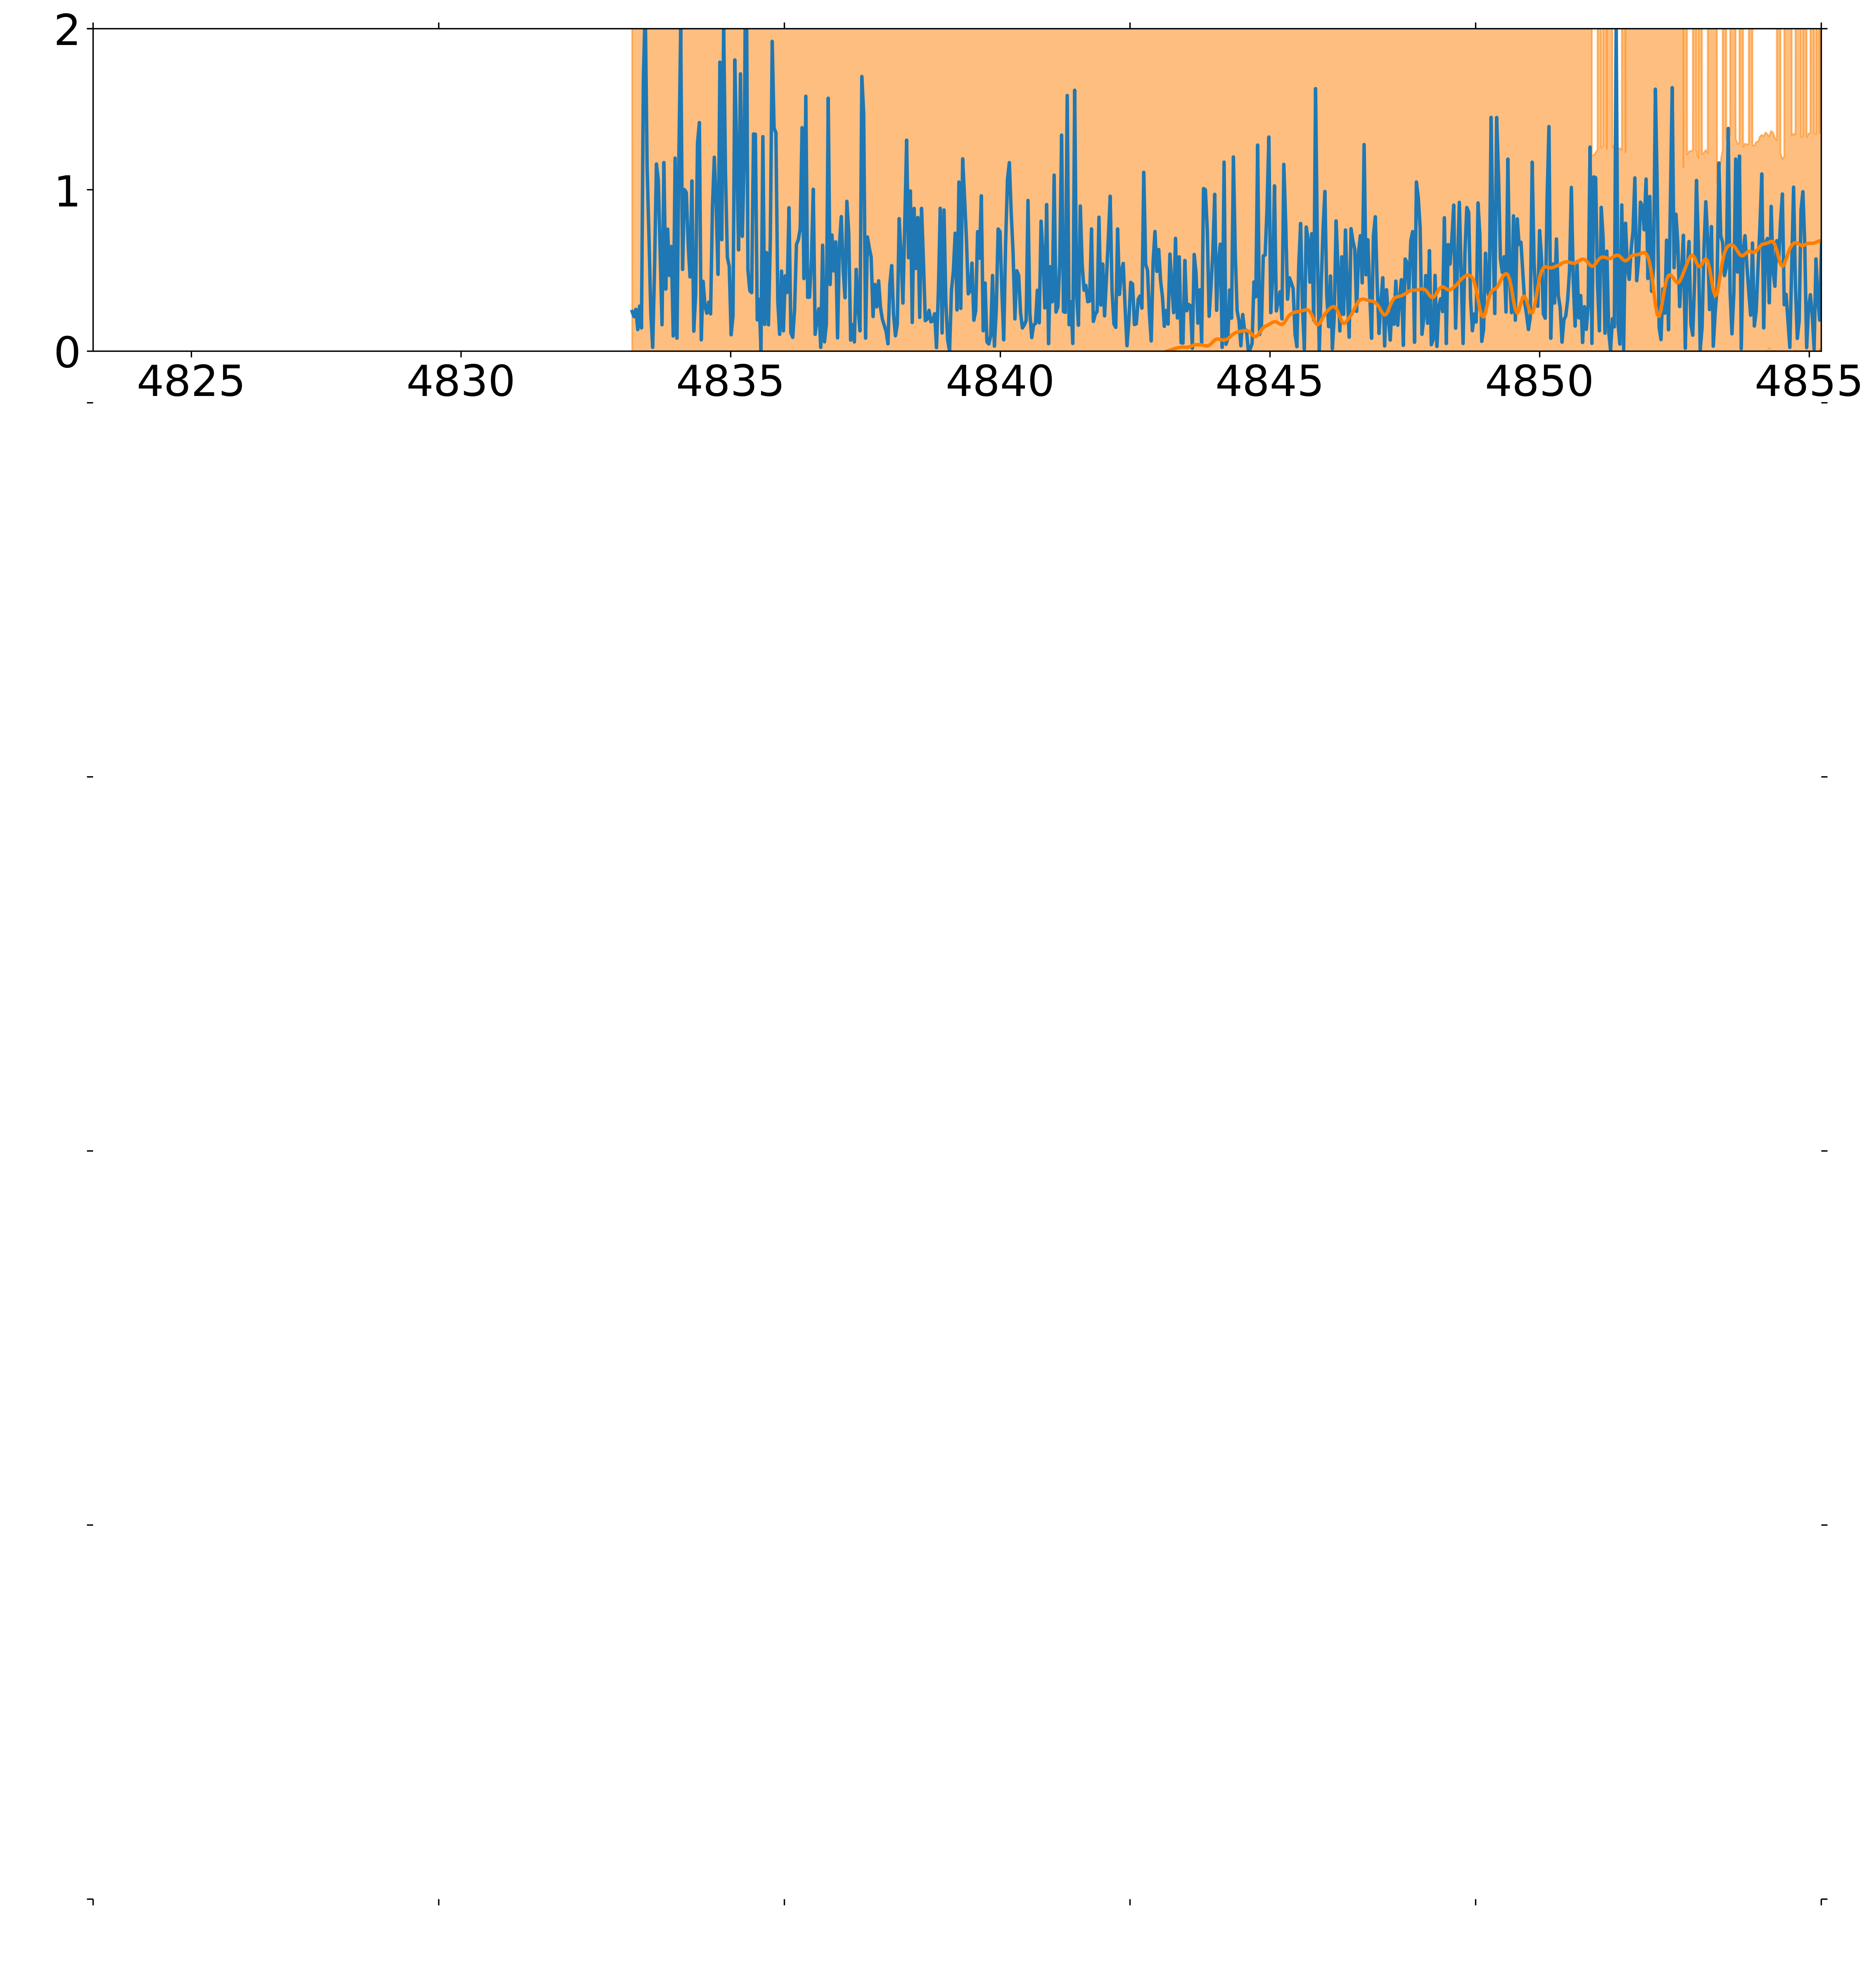

In [11]:
# make plot for individual order
for k in range(wave_fit.shape[0]):
    
    # initiate the plot
    fig = plt.figure(figsize=[18,20]);

    # combine labels
    ax = fig.add_subplot(111)

    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

#----------------------------------------------------------------------
    # write in different panel
    for i in range(5):
    
        # wavelength range
        wavelength_min = np.min(wave_fit[k,:])-10.
        wavelength_max = np.max(wave_fit[k,:])+10.
        wave_period = (wavelength_max-wavelength_min)/5.
    
        ax = fig.add_subplot(5,1,i+1)
        plt.xlim([wavelength_min+wave_period*(i),wavelength_min+wave_period*(i+1)])
    
        # plot spectrum
        plt.ylim([0.,2.])
        plt.plot(wave_fit[k,:], spec_observe_unmodulated[k*wave_fit.shape[1]:(k+1)*wave_fit.shape[1]],\
                 lw=2, label="MIKE", color=cb2[0])
        plt.plot(wave_fit[k,:], model_spec[k*wave_fit.shape[1]:(k+1)*wave_fit.shape[1]],\
                 label="Kurucz", lw=2, color=cb2[1])
    
        # share also the measurement error
        plt.fill_between(wave_fit[k,:],\
                     model_spec[k*wave_fit.shape[1]:(k+1)*wave_fit.shape[1]]\
                         - spec_err_observe_unmodulated[k*wave_fit.shape[1]:(k+1)*wave_fit.shape[1]],\
                     model_spec[k*wave_fit.shape[1]:(k+1)*wave_fit.shape[1]]\
                         + spec_err_observe_unmodulated[k*wave_fit.shape[1]:(k+1)*wave_fit.shape[1]],\
                     alpha=0.5, color=cb2[1])
    
#----------------------------------------------------------------------
        # show the masked telluric region
        for j in range(spectrum_blaze[k,:].size-smooth_length):
            if np.min(spectrum_blaze[k,j:j+smooth_length]) \
                        < 0.9*np.max(spectrum_blaze[k,j:j+smooth_length]):
                plt.fill_between([wavelength[k,j],wavelength[k,j+smooth_length]],\
                                 [-1.,-1.], [3.5,3.5], alpha=0.5, color="gray")
    
    # add axis and legend
    plt.xlabel("Wavelength [A]")
    plt.legend(loc="lower right", fontsize=28, frameon=False,\
                borderpad=0.05, labelspacing=0.1)

    # save figure
    plt.tight_layout()
    plt.savefig("Star2_Fit_" +str(k) + ".png")
    plt.close()